In [18]:
#import all the necessary libraries for this notebook

#weights and biases
# !pip install wandb --quiet
import wandb
from wandb.keras import WandbCallback

#maths and plotting
import numpy as np
import matplotlib.pyplot as plt

#machine learning
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.optimizers import adam
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

#file system
import os, glob
import tifffile
from tqdm import tqdm

In [20]:
DATA_DIR = '/kaggle/input/leeds-sciml-seaice/sciml'
train_patch_paths = np.array([os.path.basename(i[:-9]) for i in glob.glob(f'{DATA_DIR}/train/*_sar.tiff')])
test_patch_paths = np.array([os.path.basename(i[:-9]) for i in glob.glob(f'{DATA_DIR}/test/*_sar.tiff')])

#display patch paths
train_patch_paths

array(['Patch20190127_133_720_720', 'Patch20191216_17_240_1200',
       'Patch20190104_215_1200_480', ..., 'Patch20190102_28_120_1320',
       'Patch20190104_281_1560_840', 'Patch20190102_182_1320_600'],
      dtype='<U27')

In [22]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

def load_img(path):
    img = tifffile.imread(path)
    return img

class DataGenerator(Sequence):
    def __init__(self, patch_paths, data_dir, batch_size, split='train', augment=False):
        self.patch_paths = patch_paths
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.split = split
        self.is_test = split == 'test'
        self.len = len(self.patch_paths) // self.batch_size

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        batch_paths = self.patch_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X_sar, X_ms, y = [], [], []

        for patch_path in batch_paths:
            try:
                sar_path = self.data_dir / self.split / f'{patch_path}_sar.tiff'
                ms_path = self.data_dir / self.split / f'{patch_path}_vis.tiff'
                
                sar_arr = load_img(sar_path)
                ms_arr = load_img(ms_path)
                
                X_sar.append(sar_arr)
                X_ms.append(ms_arr)

                if not self.is_test:
                    label_path = self.data_dir / self.split / f'{patch_path}_ref.tiff'
                    label_arr = load_img(label_path)
                    y.append(label_arr)

            except FileNotFoundError as fnfe:
                print(f'File not found: {fnfe}')
                continue
            except Exception as e:
                print(f'Unexpected error: {e}')
                raise

        X_sar = np.expand_dims(np.array(X_sar), -1)[:, ::3, ::3, :]
        X_ms = np.array(X_ms)

        if not self.is_test:
            y = np.expand_dims(np.array(y), -1)
            return [X_sar, X_ms], y
        else:
            return [X_sar, X_ms], [None]*len(X_sar)

batch_size = 16

# Split data into train and test sets
train_patch_paths, val_patch_paths = train_test_split(train_patch_paths, test_size=0.1, random_state=42)
train_generator = DataGenerator(train_patch_paths, DATA_DIR, batch_size,augment=True)
val_generator = DataGenerator(val_patch_paths, DATA_DIR, batch_size)
test_generator = DataGenerator(test_patch_paths, DATA_DIR, batch_size, split='test')

In [24]:
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    return x

def unet():
    # Input layers
    input_sar = Input((240, 240, 1))
    input_ms = Input((240, 240, 3))

    # Concatenate inputs
    concat = concatenate([input_sar, input_ms], axis=-1)

    # Encoding path
    conv1 = conv_block(concat, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 256)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bridge
    conv5 = conv_block(pool4, 512)
    drop5 = Dropout(0.5)(conv5)

    # Decoding path
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = conv_block(merge6, 128)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = conv_block(merge7, 64)

    # Output layers
    output = Conv2D(1, 1, activation='sigmoid')(conv7)
    output = UpSampling2D(size=(4, 4))(output)

    # Model
    model = Model(inputs=[input_sar, input_ms], outputs=output)

    return model

# Create model
model = unet()


In [26]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy

initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, 
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
import wandb
from wandb.keras import WandbCallback

# Initialize a new W&B run
wandb_enabled = True

# Common arguments
fit_args = {
    "x": train_generator,
    "validation_data": val_generator,
    "epochs": 100,
    "use_multiprocessing": True,
    "workers": 6,
    "callbacks": [EarlyStopping(patience=10, verbose=1)]
}

if wandb_enabled:
    wandb.init(entity='purge', project='sea-ice-segmentation')
    fit_args["callbacks"].append(WandbCallback())

history = model.fit(**fit_args)

if wandb_enabled:
    wandb.finish()

Epoch 1/100


2023-07-03 01:36:06.248143: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


79/79 [==============================] - ETA: 0s - loss: 0.5769 - accuracy: 0.8172 - mean_io_u_2: 0.3044

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.6s


79/79 [==============================] - 38s 374ms/step - loss: 0.5769 - accuracy: 0.8172 - mean_io_u_2: 0.3044 - val_loss: 0.5414 - val_accuracy: 0.8840 - val_mean_io_u_2: 0.4348
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.9057 - mean_io_u_2: 0.5783

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 30s 362ms/step - loss: 0.5405 - accuracy: 0.9057 - mean_io_u_2: 0.5783 - val_loss: 0.5323 - val_accuracy: 0.9044 - val_mean_io_u_2: 0.5853
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 0.5331 - accuracy: 0.9247 - mean_io_u_2: 0.6660

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 32s 386ms/step - loss: 0.5331 - accuracy: 0.9247 - mean_io_u_2: 0.6660 - val_loss: 0.5198 - val_accuracy: 0.9489 - val_mean_io_u_2: 0.7157
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.9242 - mean_io_u_2: 0.7084

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 32s 368ms/step - loss: 0.5337 - accuracy: 0.9242 - mean_io_u_2: 0.7084 - val_loss: 0.5192 - val_accuracy: 0.9407 - val_mean_io_u_2: 0.6994
Epoch 5/100
79/79 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.9354 - mean_io_u_2: 0.7108

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 29s 354ms/step - loss: 0.5287 - accuracy: 0.9354 - mean_io_u_2: 0.7108 - val_loss: 0.5154 - val_accuracy: 0.9548 - val_mean_io_u_2: 0.7232
Epoch 6/100
79/79 [==============================] - 25s 301ms/step - loss: 0.5295 - accuracy: 0.9355 - mean_io_u_2: 0.7229 - val_loss: 0.5158 - val_accuracy: 0.9552 - val_mean_io_u_2: 0.7495
Epoch 7/100
79/79 [==============================] - 24s 282ms/step - loss: 0.5282 - accuracy: 0.9378 - mean_io_u_2: 0.7262 - val_loss: 0.5221 - val_accuracy: 0.9322 - val_mean_io_u_2: 0.7008
Epoch 8/100
79/79 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.9379 - mean_io_u_2: 0.7482

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 30s 355ms/step - loss: 0.5279 - accuracy: 0.9379 - mean_io_u_2: 0.7482 - val_loss: 0.5151 - val_accuracy: 0.9553 - val_mean_io_u_2: 0.7254
Epoch 9/100
79/79 [==============================] - 25s 292ms/step - loss: 0.5250 - accuracy: 0.9449 - mean_io_u_2: 0.7470 - val_loss: 0.5170 - val_accuracy: 0.9465 - val_mean_io_u_2: 0.7045
Epoch 10/100
79/79 [==============================] - ETA: 0s - loss: 0.5255 - accuracy: 0.9433 - mean_io_u_2: 0.7566

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 29s 352ms/step - loss: 0.5255 - accuracy: 0.9433 - mean_io_u_2: 0.7566 - val_loss: 0.5146 - val_accuracy: 0.9545 - val_mean_io_u_2: 0.7594
Epoch 11/100
79/79 [==============================] - ETA: 0s - loss: 0.5255 - accuracy: 0.9444 - mean_io_u_2: 0.7606

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 31s 368ms/step - loss: 0.5255 - accuracy: 0.9444 - mean_io_u_2: 0.7606 - val_loss: 0.5133 - val_accuracy: 0.9585 - val_mean_io_u_2: 0.7590
Epoch 12/100
79/79 [==============================] - 24s 287ms/step - loss: 0.5274 - accuracy: 0.9386 - mean_io_u_2: 0.7404 - val_loss: 0.5305 - val_accuracy: 0.9086 - val_mean_io_u_2: 0.7146
Epoch 13/100
79/79 [==============================] - 25s 296ms/step - loss: 0.5266 - accuracy: 0.9418 - mean_io_u_2: 0.7984 - val_loss: 0.5134 - val_accuracy: 0.9570 - val_mean_io_u_2: 0.7469
Epoch 14/100
79/79 [==============================] - ETA: 0s - loss: 0.5246 - accuracy: 0.9464 - mean_io_u_2: 0.7962

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 29s 348ms/step - loss: 0.5246 - accuracy: 0.9464 - mean_io_u_2: 0.7962 - val_loss: 0.5129 - val_accuracy: 0.9585 - val_mean_io_u_2: 0.7573
Epoch 15/100
79/79 [==============================] - 25s 296ms/step - loss: 0.5231 - accuracy: 0.9501 - mean_io_u_2: 0.7938 - val_loss: 0.5131 - val_accuracy: 0.9589 - val_mean_io_u_2: 0.7679
Epoch 16/100
79/79 [==============================] - 22s 253ms/step - loss: 0.5227 - accuracy: 0.9507 - mean_io_u_2: 0.7901 - val_loss: 0.5133 - val_accuracy: 0.9563 - val_mean_io_u_2: 0.7732
Epoch 17/100
79/79 [==============================] - 25s 291ms/step - loss: 0.5231 - accuracy: 0.9502 - mean_io_u_2: 0.7954 - val_loss: 0.5138 - val_accuracy: 0.9548 - val_mean_io_u_2: 0.7111
Epoch 18/100
79/79 [==============================] - 25s 300ms/step - loss: 0.5256 - accuracy: 0.9422 - mean_io_u_2: 0.7838 - val_loss: 0.5158 - val_accuracy: 0.9493 - val_mean_io_u_2: 0.7106
Epoch 19/100
79/79 [============================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 30s 354ms/step - loss: 0.5217 - accuracy: 0.9527 - mean_io_u_2: 0.8075 - val_loss: 0.5124 - val_accuracy: 0.9598 - val_mean_io_u_2: 0.7614
Epoch 25/100
79/79 [==============================] - 25s 295ms/step - loss: 0.5234 - accuracy: 0.9481 - mean_io_u_2: 0.8049 - val_loss: 0.5173 - val_accuracy: 0.9439 - val_mean_io_u_2: 0.7101
Epoch 26/100
79/79 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.9467 - mean_io_u_2: 0.8122

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 28s 335ms/step - loss: 0.5243 - accuracy: 0.9467 - mean_io_u_2: 0.8122 - val_loss: 0.5123 - val_accuracy: 0.9609 - val_mean_io_u_2: 0.8438
Epoch 27/100
79/79 [==============================] - 25s 290ms/step - loss: 0.5212 - accuracy: 0.9540 - mean_io_u_2: 0.8292 - val_loss: 0.5132 - val_accuracy: 0.9561 - val_mean_io_u_2: 0.8449
Epoch 28/100
79/79 [==============================] - 24s 290ms/step - loss: 0.5209 - accuracy: 0.9550 - mean_io_u_2: 0.8175 - val_loss: 0.5150 - val_accuracy: 0.9523 - val_mean_io_u_2: 0.7601
Epoch 29/100
79/79 [==============================] - 24s 287ms/step - loss: 0.5210 - accuracy: 0.9545 - mean_io_u_2: 0.8194 - val_loss: 0.5130 - val_accuracy: 0.9558 - val_mean_io_u_2: 0.7617
Epoch 30/100
79/79 [==============================] - 24s 286ms/step - loss: 0.5204 - accuracy: 0.9559 - mean_io_u_2: 0.8250 - val_loss: 0.5126 - val_accuracy: 0.9586 - val_mean_io_u_2: 0.7782
Epoch 31/100
79/79 [============================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 30s 356ms/step - loss: 0.5192 - accuracy: 0.9589 - mean_io_u_2: 0.8196 - val_loss: 0.5118 - val_accuracy: 0.9600 - val_mean_io_u_2: 0.7341
Epoch 33/100
79/79 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.9592 - mean_io_u_2: 0.8189

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 30s 360ms/step - loss: 0.5192 - accuracy: 0.9592 - mean_io_u_2: 0.8189 - val_loss: 0.5109 - val_accuracy: 0.9624 - val_mean_io_u_2: 0.7327
Epoch 34/100
79/79 [==============================] - 25s 298ms/step - loss: 0.5194 - accuracy: 0.9583 - mean_io_u_2: 0.8142 - val_loss: 0.5116 - val_accuracy: 0.9605 - val_mean_io_u_2: 0.6875
Epoch 35/100
79/79 [==============================] - 25s 298ms/step - loss: 0.5185 - accuracy: 0.9602 - mean_io_u_2: 0.8172 - val_loss: 0.5125 - val_accuracy: 0.9571 - val_mean_io_u_2: 0.8122
Epoch 36/100
79/79 [==============================] - 25s 292ms/step - loss: 0.5189 - accuracy: 0.9597 - mean_io_u_2: 0.8447 - val_loss: 0.5110 - val_accuracy: 0.9625 - val_mean_io_u_2: 0.8509
Epoch 37/100
79/79 [==============================] - ETA: 0s - loss: 0.5178 - accuracy: 0.9619 - mean_io_u_2: 0.8381

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 30s 353ms/step - loss: 0.5178 - accuracy: 0.9619 - mean_io_u_2: 0.8381 - val_loss: 0.5100 - val_accuracy: 0.9657 - val_mean_io_u_2: 0.7784
Epoch 38/100
79/79 [==============================] - 25s 291ms/step - loss: 0.5201 - accuracy: 0.9565 - mean_io_u_2: 0.8310 - val_loss: 0.5111 - val_accuracy: 0.9628 - val_mean_io_u_2: 0.8599
Epoch 39/100
79/79 [==============================] - 25s 296ms/step - loss: 0.5177 - accuracy: 0.9620 - mean_io_u_2: 0.8581 - val_loss: 0.5100 - val_accuracy: 0.9639 - val_mean_io_u_2: 0.8232
Epoch 40/100
79/79 [==============================] - 24s 291ms/step - loss: 0.5172 - accuracy: 0.9635 - mean_io_u_2: 0.8437 - val_loss: 0.5103 - val_accuracy: 0.9651 - val_mean_io_u_2: 0.8413
Epoch 41/100
79/79 [==============================] - 24s 289ms/step - loss: 0.5182 - accuracy: 0.9613 - mean_io_u_2: 0.8403 - val_loss: 0.5105 - val_accuracy: 0.9649 - val_mean_io_u_2: 0.8344
Epoch 42/100
79/79 [============================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 30s 357ms/step - loss: 0.5167 - accuracy: 0.9644 - mean_io_u_2: 0.8583 - val_loss: 0.5099 - val_accuracy: 0.9646 - val_mean_io_u_2: 0.8821
Epoch 46/100
79/79 [==============================] - 25s 295ms/step - loss: 0.5160 - accuracy: 0.9662 - mean_io_u_2: 0.8680 - val_loss: 0.5104 - val_accuracy: 0.9629 - val_mean_io_u_2: 0.8465
Epoch 47/100
79/79 [==============================] - ETA: 0s - loss: 0.5153 - accuracy: 0.9676 - mean_io_u_2: 0.8659

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 30s 361ms/step - loss: 0.5153 - accuracy: 0.9676 - mean_io_u_2: 0.8659 - val_loss: 0.5091 - val_accuracy: 0.9658 - val_mean_io_u_2: 0.8481
Epoch 48/100
79/79 [==============================] - 25s 298ms/step - loss: 0.5161 - accuracy: 0.9660 - mean_io_u_2: 0.8728 - val_loss: 0.5100 - val_accuracy: 0.9663 - val_mean_io_u_2: 0.8735
Epoch 49/100
79/79 [==============================] - 25s 298ms/step - loss: 0.5155 - accuracy: 0.9672 - mean_io_u_2: 0.8696 - val_loss: 0.5093 - val_accuracy: 0.9673 - val_mean_io_u_2: 0.8357
Epoch 50/100
79/79 [==============================] - 25s 293ms/step - loss: 0.5167 - accuracy: 0.9644 - mean_io_u_2: 0.8718 - val_loss: 0.5132 - val_accuracy: 0.9540 - val_mean_io_u_2: 0.8294
Epoch 51/100
79/79 [==============================] - 24s 293ms/step - loss: 0.5210 - accuracy: 0.9537 - mean_io_u_2: 0.8680 - val_loss: 0.5115 - val_accuracy: 0.9592 - val_mean_io_u_2: 0.8249
Epoch 52/100
79/79 [============================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 29s 351ms/step - loss: 0.5145 - accuracy: 0.9692 - mean_io_u_2: 0.8899 - val_loss: 0.5085 - val_accuracy: 0.9673 - val_mean_io_u_2: 0.8144
Epoch 58/100
79/79 [==============================] - ETA: 0s - loss: 0.5137 - accuracy: 0.9712 - mean_io_u_2: 0.8968

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 29s 347ms/step - loss: 0.5137 - accuracy: 0.9712 - mean_io_u_2: 0.8968 - val_loss: 0.5080 - val_accuracy: 0.9691 - val_mean_io_u_2: 0.8883
Epoch 59/100
79/79 [==============================] - 25s 287ms/step - loss: 0.5140 - accuracy: 0.9702 - mean_io_u_2: 0.8916 - val_loss: 0.5097 - val_accuracy: 0.9667 - val_mean_io_u_2: 0.9120
Epoch 60/100
79/79 [==============================] - 26s 299ms/step - loss: 0.5147 - accuracy: 0.9690 - mean_io_u_2: 0.8965 - val_loss: 0.5109 - val_accuracy: 0.9640 - val_mean_io_u_2: 0.8890
Epoch 61/100
79/79 [==============================] - 25s 298ms/step - loss: 0.5163 - accuracy: 0.9651 - mean_io_u_2: 0.8846 - val_loss: 0.5109 - val_accuracy: 0.9616 - val_mean_io_u_2: 0.8891
Epoch 62/100
79/79 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.9671 - mean_io_u_2: 0.8895

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 30s 355ms/step - loss: 0.5154 - accuracy: 0.9671 - mean_io_u_2: 0.8895 - val_loss: 0.5077 - val_accuracy: 0.9691 - val_mean_io_u_2: 0.8983
Epoch 63/100
79/79 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.9717 - mean_io_u_2: 0.9105

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 30s 360ms/step - loss: 0.5135 - accuracy: 0.9717 - mean_io_u_2: 0.9105 - val_loss: 0.5077 - val_accuracy: 0.9705 - val_mean_io_u_2: 0.9058
Epoch 64/100
79/79 [==============================] - 26s 303ms/step - loss: 0.5169 - accuracy: 0.9624 - mean_io_u_2: 0.8945 - val_loss: 0.5083 - val_accuracy: 0.9673 - val_mean_io_u_2: 0.8805
Epoch 65/100
79/79 [==============================] - 24s 289ms/step - loss: 0.5144 - accuracy: 0.9694 - mean_io_u_2: 0.8994 - val_loss: 0.5089 - val_accuracy: 0.9656 - val_mean_io_u_2: 0.8570
Epoch 66/100
79/79 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.9723 - mean_io_u_2: 0.9101

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 30s 365ms/step - loss: 0.5132 - accuracy: 0.9723 - mean_io_u_2: 0.9101 - val_loss: 0.5061 - val_accuracy: 0.9708 - val_mean_io_u_2: 0.8721
Epoch 67/100
79/79 [==============================] - 25s 293ms/step - loss: 0.5125 - accuracy: 0.9727 - mean_io_u_2: 0.9088 - val_loss: 0.5076 - val_accuracy: 0.9710 - val_mean_io_u_2: 0.9110
Epoch 68/100
79/79 [==============================] - 24s 289ms/step - loss: 0.5137 - accuracy: 0.9710 - mean_io_u_2: 0.9108 - val_loss: 0.5080 - val_accuracy: 0.9695 - val_mean_io_u_2: 0.8955
Epoch 69/100
79/79 [==============================] - 25s 301ms/step - loss: 0.5147 - accuracy: 0.9686 - mean_io_u_2: 0.9026 - val_loss: 0.5080 - val_accuracy: 0.9685 - val_mean_io_u_2: 0.8726
Epoch 70/100
79/79 [==============================] - 25s 293ms/step - loss: 0.5127 - accuracy: 0.9729 - mean_io_u_2: 0.9130 - val_loss: 0.5067 - val_accuracy: 0.9721 - val_mean_io_u_2: 0.9153
Epoch 71/100
79/79 [============================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 29s 346ms/step - loss: 0.5115 - accuracy: 0.9751 - mean_io_u_2: 0.9178 - val_loss: 0.5054 - val_accuracy: 0.9734 - val_mean_io_u_2: 0.8878
Epoch 72/100
79/79 [==============================] - 26s 293ms/step - loss: 0.5112 - accuracy: 0.9759 - mean_io_u_2: 0.9137 - val_loss: 0.5058 - val_accuracy: 0.9734 - val_mean_io_u_2: 0.8907
Epoch 73/100
79/79 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.9763 - mean_io_u_2: 0.9150

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 30s 363ms/step - loss: 0.5108 - accuracy: 0.9763 - mean_io_u_2: 0.9150 - val_loss: 0.5049 - val_accuracy: 0.9741 - val_mean_io_u_2: 0.9074
Epoch 74/100
79/79 [==============================] - 25s 296ms/step - loss: 0.5120 - accuracy: 0.9750 - mean_io_u_2: 0.9195 - val_loss: 0.5067 - val_accuracy: 0.9717 - val_mean_io_u_2: 0.9007
Epoch 75/100
79/79 [==============================] - ETA: 0s - loss: 0.5117 - accuracy: 0.9753 - mean_io_u_2: 0.9101

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 29s 350ms/step - loss: 0.5117 - accuracy: 0.9753 - mean_io_u_2: 0.9101 - val_loss: 0.5043 - val_accuracy: 0.9757 - val_mean_io_u_2: 0.9073
Epoch 76/100
79/79 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.9772 - mean_io_u_2: 0.9207

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 33s 400ms/step - loss: 0.5105 - accuracy: 0.9772 - mean_io_u_2: 0.9207 - val_loss: 0.5042 - val_accuracy: 0.9757 - val_mean_io_u_2: 0.8899
Epoch 77/100
79/79 [==============================] - 25s 290ms/step - loss: 0.5108 - accuracy: 0.9765 - mean_io_u_2: 0.9168 - val_loss: 0.5066 - val_accuracy: 0.9701 - val_mean_io_u_2: 0.8619
Epoch 78/100
79/79 [==============================] - 25s 293ms/step - loss: 0.5140 - accuracy: 0.9689 - mean_io_u_2: 0.9023 - val_loss: 0.5086 - val_accuracy: 0.9646 - val_mean_io_u_2: 0.8888
Epoch 79/100
79/79 [==============================] - 24s 287ms/step - loss: 0.5115 - accuracy: 0.9746 - mean_io_u_2: 0.9041 - val_loss: 0.5047 - val_accuracy: 0.9746 - val_mean_io_u_2: 0.9003
Epoch 80/100
79/79 [==============================] - 25s 300ms/step - loss: 0.5097 - accuracy: 0.9789 - mean_io_u_2: 0.9238 - val_loss: 0.5043 - val_accuracy: 0.9756 - val_mean_io_u_2: 0.9079
Epoch 81/100
79/79 [============================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 31s 372ms/step - loss: 0.5095 - accuracy: 0.9794 - mean_io_u_2: 0.9283 - val_loss: 0.5039 - val_accuracy: 0.9765 - val_mean_io_u_2: 0.9081
Epoch 83/100
79/79 [==============================] - 25s 303ms/step - loss: 0.5093 - accuracy: 0.9798 - mean_io_u_2: 0.9312 - val_loss: 0.5045 - val_accuracy: 0.9745 - val_mean_io_u_2: 0.8997
Epoch 84/100
79/79 [==============================] - 25s 291ms/step - loss: 0.5100 - accuracy: 0.9787 - mean_io_u_2: 0.9270 - val_loss: 0.5043 - val_accuracy: 0.9747 - val_mean_io_u_2: 0.9062
Epoch 85/100
79/79 [==============================] - 25s 292ms/step - loss: 0.5096 - accuracy: 0.9792 - mean_io_u_2: 0.9275 - val_loss: 0.5046 - val_accuracy: 0.9752 - val_mean_io_u_2: 0.9013
Epoch 86/100
79/79 [==============================] - ETA: 0s - loss: 0.5094 - accuracy: 0.9796 - mean_io_u_2: 0.9305

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 29s 349ms/step - loss: 0.5094 - accuracy: 0.9796 - mean_io_u_2: 0.9305 - val_loss: 0.5036 - val_accuracy: 0.9773 - val_mean_io_u_2: 0.9020
Epoch 87/100
79/79 [==============================] - 25s 294ms/step - loss: 0.5092 - accuracy: 0.9800 - mean_io_u_2: 0.9308 - val_loss: 0.5043 - val_accuracy: 0.9772 - val_mean_io_u_2: 0.9272
Epoch 88/100
79/79 [==============================] - 25s 295ms/step - loss: 0.5101 - accuracy: 0.9779 - mean_io_u_2: 0.9246 - val_loss: 0.5085 - val_accuracy: 0.9645 - val_mean_io_u_2: 0.8925
Epoch 89/100
79/79 [==============================] - 24s 288ms/step - loss: 0.5100 - accuracy: 0.9782 - mean_io_u_2: 0.9217 - val_loss: 0.5047 - val_accuracy: 0.9753 - val_mean_io_u_2: 0.8967
Epoch 90/100
79/79 [==============================] - 25s 298ms/step - loss: 0.5121 - accuracy: 0.9731 - mean_io_u_2: 0.9137 - val_loss: 0.5052 - val_accuracy: 0.9732 - val_mean_io_u_2: 0.9103
Epoch 91/100
79/79 [============================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 30s 366ms/step - loss: 0.5084 - accuracy: 0.9820 - mean_io_u_2: 0.9392 - val_loss: 0.5033 - val_accuracy: 0.9784 - val_mean_io_u_2: 0.9231
Epoch 96/100
79/79 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.9827 - mean_io_u_2: 0.9421

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.4s


79/79 [==============================] - 32s 380ms/step - loss: 0.5081 - accuracy: 0.9827 - mean_io_u_2: 0.9421 - val_loss: 0.5031 - val_accuracy: 0.9790 - val_mean_io_u_2: 0.9229
Epoch 97/100
79/79 [==============================] - 25s 305ms/step - loss: 0.5079 - accuracy: 0.9831 - mean_io_u_2: 0.9427 - val_loss: 0.5040 - val_accuracy: 0.9776 - val_mean_io_u_2: 0.9280
Epoch 98/100
79/79 [==============================] - ETA: 0s - loss: 0.5080 - accuracy: 0.9829 - mean_io_u_2: 0.9428

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230703_013513-05awmd6x/files/model-best)... Done. 0.3s


79/79 [==============================] - 30s 365ms/step - loss: 0.5080 - accuracy: 0.9829 - mean_io_u_2: 0.9428 - val_loss: 0.5031 - val_accuracy: 0.9787 - val_mean_io_u_2: 0.9081
Epoch 99/100
79/79 [==============================] - 26s 300ms/step - loss: 0.5079 - accuracy: 0.9833 - mean_io_u_2: 0.9402 - val_loss: 0.5031 - val_accuracy: 0.9789 - val_mean_io_u_2: 0.9246
Epoch 100/100
79/79 [==============================] - 25s 300ms/step - loss: 0.5078 - accuracy: 0.9835 - mean_io_u_2: 0.9421 - val_loss: 0.5031 - val_accuracy: 0.9795 - val_mean_io_u_2: 0.9263


Text(0, 0.5, 'loss')

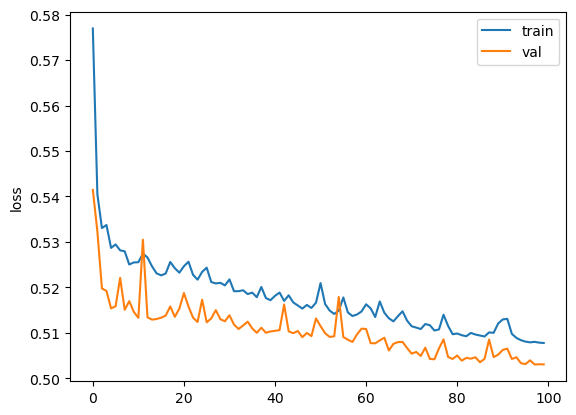

In [29]:
#@title Now plot the results of the training run:

metric_to_plot = 'loss' #@param ['loss', 'accuracy', 'mean_io_u']

ys = history.history[metric_to_plot]
ys_val = history.history['val_'+metric_to_plot]
num_epochs = len(ys)
plt.plot(range(num_epochs), ys, label='train')
plt.plot(range(num_epochs), ys_val, label='val')
plt.legend()
plt.ylabel(metric_to_plot)

In [30]:
#@markdown You need to specify the threshold value, which determines the threshold for classifying pixels as foreground or background. Adjusting this value may affect the performance of the segmentation.

threshold = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
threshold

0.5

1/1 [==============================] - 0s 387ms/step


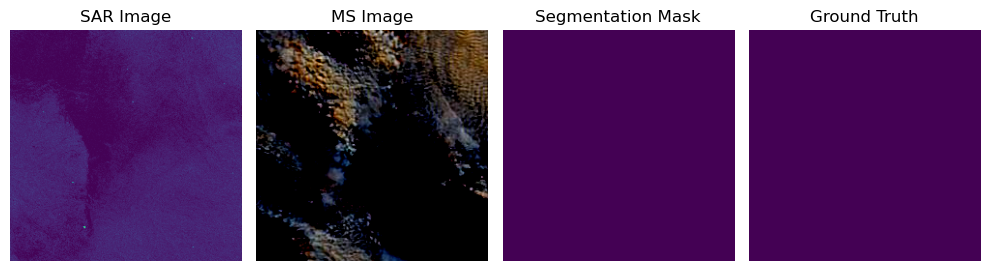

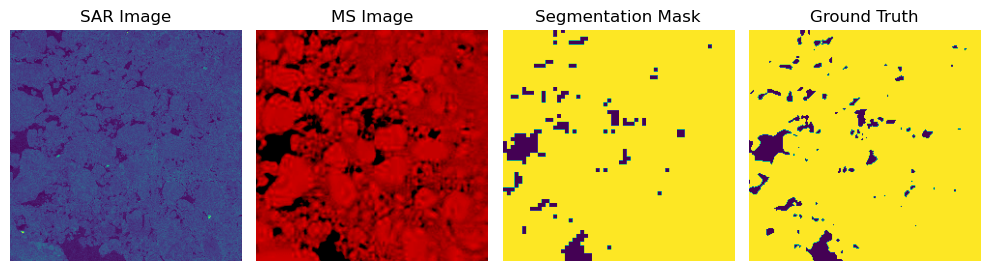

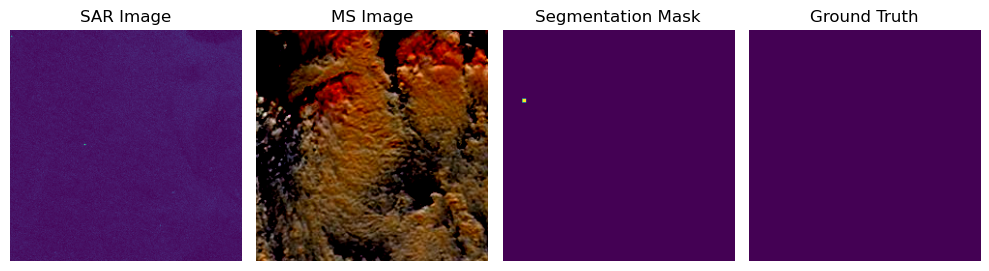

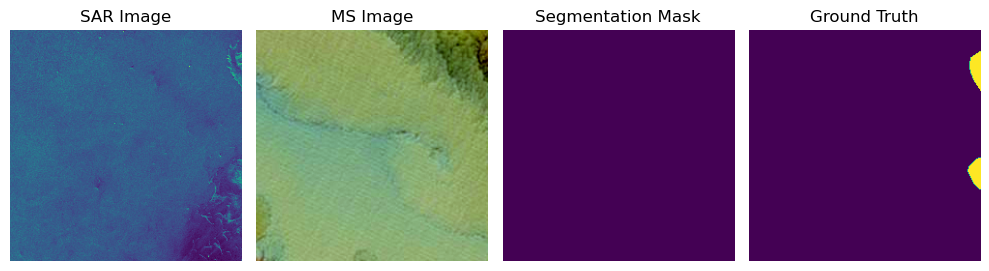

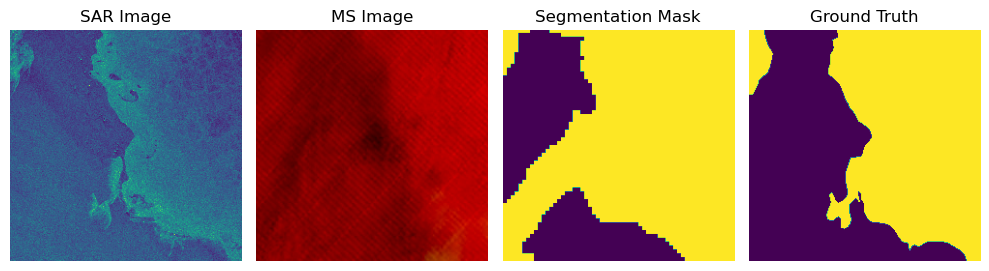

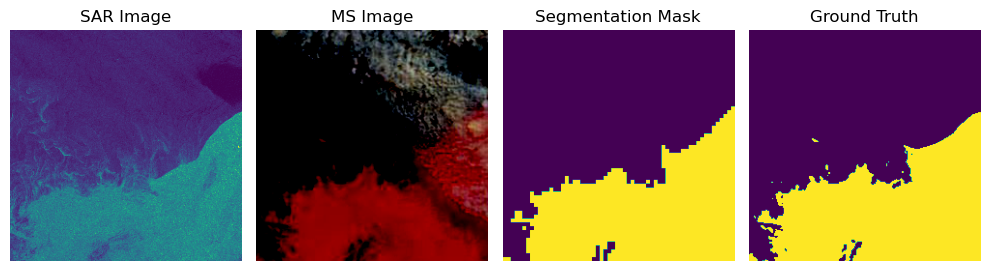

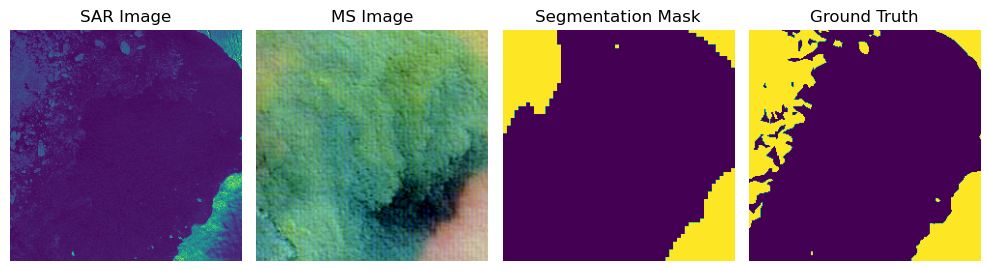

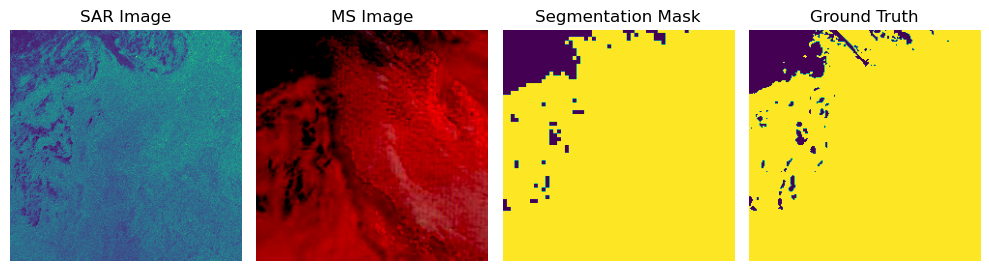

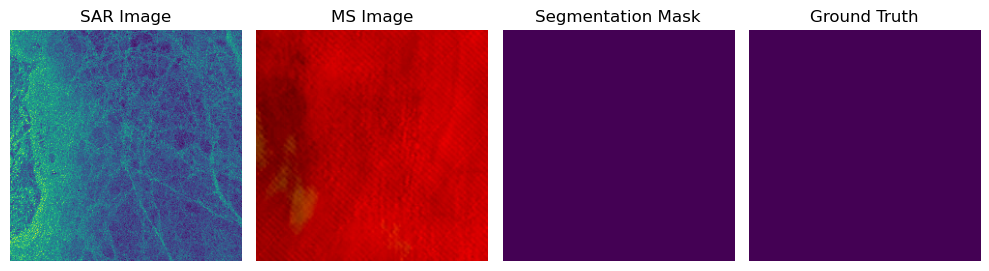

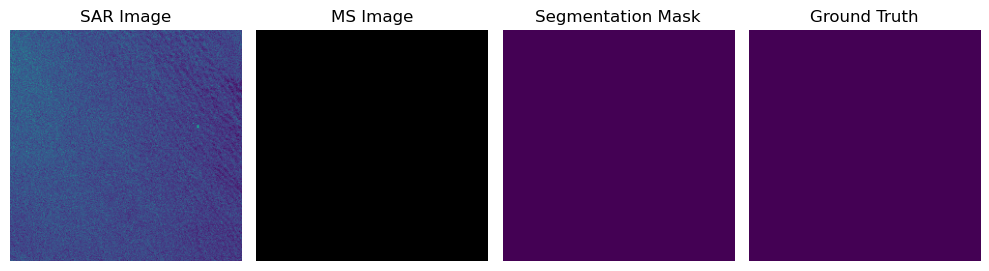

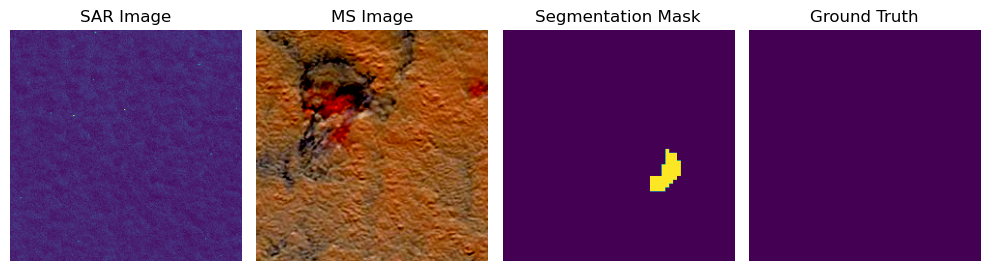

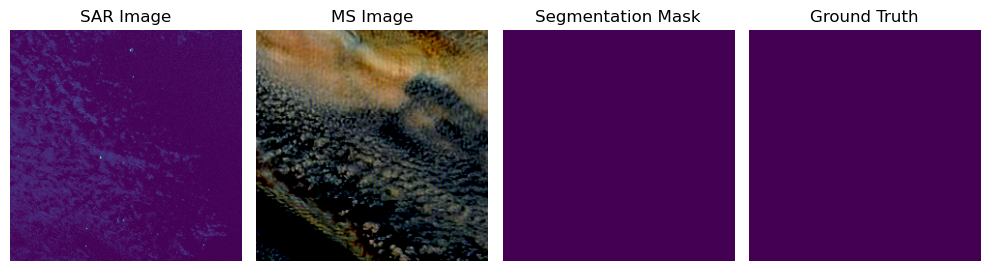

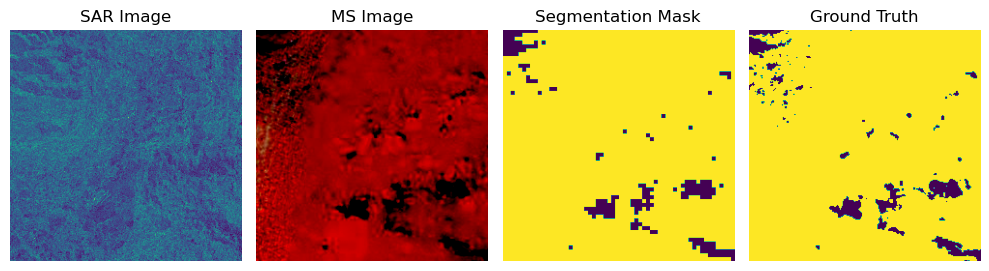

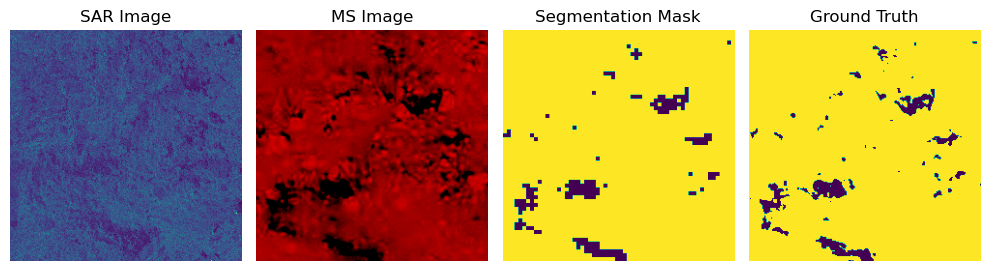

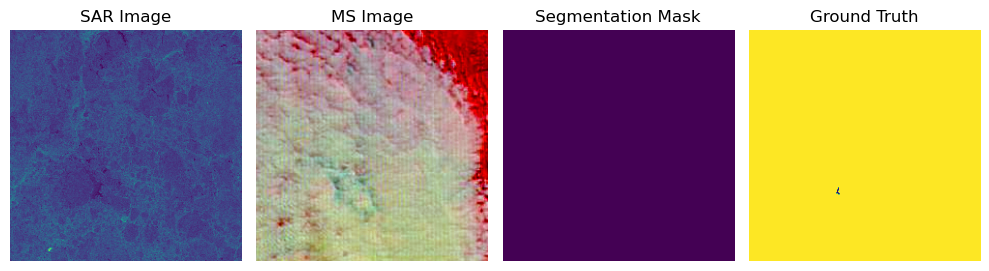

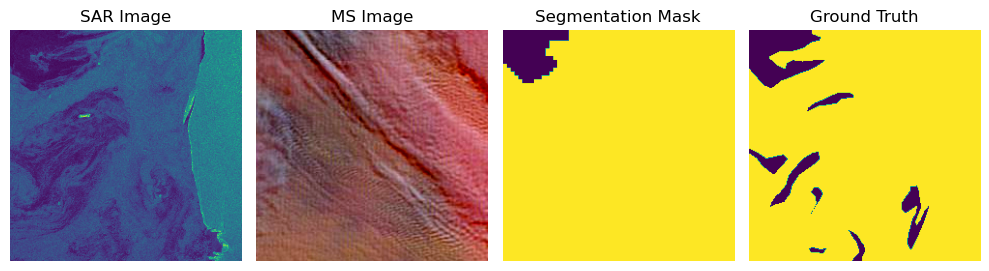

In [31]:
preds = model.predict(val_generator,steps=1)

(X_sar_test, X_ms_test), y_test = next(iter(val_generator))

for i in range(preds.shape[0]):
    plt.figure(figsize=(10, 5))
    plt.subplot(141)
    plt.imshow(X_sar_test[i,:,:,:])
    plt.title('SAR Image')
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(X_ms_test[i,:,:,:])
    plt.title('MS Image')
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(preds[i,:,:,0]>threshold)
    plt.title('Segmentation Mask')
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(y_test[i,:,:,0])
    plt.title('Ground Truth')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [32]:
import pandas as pd

#ref:https://www.kaggle.com/paulorzp/run-length-encode-and-decode.
def rle_encode(mask):
    '''
    mask: numpy array binary mask
    1 - mask
    0 - background
    Returns encoded run length
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Predict on test data
predictions = model.predict(test_generator)

# Generate submission DataFrame
submission_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

for i, patch_path in enumerate(test_patch_paths):
    image_id = os.path.basename(patch_path)
    mask = predictions[i, :, :, 0] > threshold
    encoded_pixels = rle_encode(mask)
    submission_df.loc[i] = [image_id, encoded_pixels]

# Save submission DataFrame to CSV file
submission_df.to_csv('submission.csv', index=False)

22/22 [==============================] - 17s 784ms/step
